# 새로운 모델 적용

In [1]:
## 데이터를 불러 온다
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

df_train = pd.read_csv('archive/train.csv')
df_test = pd.read_csv('archive/test.csv')
df_park = pd.read_csv('archive/park_dimensions.csv')

df_train.shape, df_test.shape

((46244, 25), (65779, 24))

In [2]:
## 원본 데이터 보존
train = df_train
test = df_test
park = df_park

In [3]:
## 전처리
train[['plate_x', 'plate_z']] = train[['plate_x', 'plate_z']].apply(lambda x : x * 0.3048)
train[['pitch_mph', 'launch_speed']] = train[['pitch_mph', 'launch_speed']].apply(lambda x : x * 1.60934)

test[['plate_x', 'plate_z']] = test[['plate_x', 'plate_z']].apply(lambda x : x * 0.3048)
test[['pitch_mph', 'launch_speed']] = test[['pitch_mph', 'launch_speed']].apply(lambda x : x * 1.60934)

park[['LF_Dim', 'CF_Dim', 'RF_Dim', 'LF_W', 'CF_W', 'RF_W']] = park[['LF_Dim', 'CF_Dim', 'RF_Dim', 'LF_W', 'CF_W', 'RF_W']].apply(lambda x: x * 0.3048)

# 컬럼명 변경
train.rename(columns= {'pitch_mph' : 'pitch_kph'})
test.rename(columns= {'pitch_mph' : 'pitch_kph'})

,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_kph,launch_speed,launch_angle
0,16,2021-06-23 00:00:00,MIA,TOR,MIA,"marte, starling","ray, robbie",516782,592662,0,1,fly_ball,center,Slider,14,6,0,2,1,-0.027432,0.640080,140.978184,175.418060,22.0
1,17,2021-06-23 00:00:00,MIA,TOR,MIA,"marte, starling","ray, robbie",516782,592662,0,1,ground_ball,center,Slider,14,1,1,1,2,0.204216,0.521208,142.265656,41.038170,NaN
2,18,2021-06-01 00:00:00,TOR,MIA,MIA,"marte, starling","ray, robbie",516782,592662,0,1,fly_ball,left,Slider,28,5,2,0,0,-0.152400,0.795528,143.392194,151.599828,NaN
3,19,2021-06-01 00:00:00,TOR,MIA,MIA,"marte, starling","ray, robbie",516782,592662,0,1,ground_ball,left,Slider,28,3,2,2,1,-0.137160,0.542544,145.484336,133.736154,NaN
4,32,2021-06-13 00:00:00,BOS,TOR,BOS,"hernandez, enrique","ray, robbie",571771,592662,0,1,line_drive,center,Slider,3,5,2,0,0,0.079248,0.697992,145.001534,173.969654,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65774,119513,2021-05-22 00:00:00,STL,CHC,CHC,"rizzo, anthony","mikolas, miles",519203,571945,1,0,ground_ball,left,Sinker,25,1,1,0,2,-0.091440,1.060704,146.128072,NaN,-23.0
65775,119514,2021-05-22 00:00:00,STL,CHC,CHC,"hoerner, nico","mikolas, miles",663538,571945,0,0,popup,right,Slider,25,4,2,3,2,0.423672,0.493776,136.150164,88.191832,47.0
65776,119515,2021-05-22 00:00:00,STL,CHC,CHC,"hoerner, nico","mikolas, miles",663538,571945,0,0,ground_ball,center,Sinker,25,2,1,0,2,-0.070104,0.893064,146.610874,128.103464,NaN
65777,119521,2021-05-14 00:00:00,ARI,WSH,WSH,"mercer, jordy","peralta, david",474568,444482,0,1,line_drive,center,Fastball,0,9,1,0,2,-0.188976,0.914400,115.550612,NaN,20.0


## Boosting(xgboost for gradient boosting)를 사용

In [4]:
## 훈련 검증 세트를 나눈다
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=774)
train.shape, val.shape

((36995, 25), (9249, 25))

In [5]:
target = 'is_home_run'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [6]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

C:\Users\comic\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [8]:
from sklearn.metrics import f1_score, accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print('f1 score : ', f1_score(y_val, y_pred))

검증 정확도:  0.9626986701265001
f1 score :  0.538152610441767


랜덤 포레스트 모델보다 성능이 향상 되었다.

### 하이퍼 파라미터 튜닝을 통한 최적화

In [9]:
## 타겟의 비율을 맞춰주기 위해 weight를 사용
vc = y_train.value_counts().tolist()
vc

[35003, 1992]

In [10]:
# sum(negative instances) / sum(positive instances)
ratio = float(vc[0]/vc[1])
ratio

17.571787148594378

In [ ]:

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=15,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
    scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=100
         ) # 100 rounds 동안 스코어의 개선이 없으면 멈춤

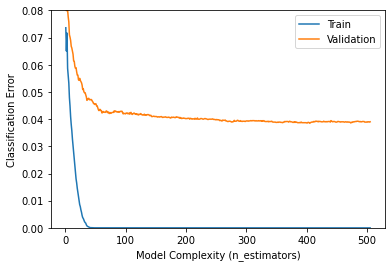

In [51]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.0, 0.08)) # Zoom in
plt.legend();

In [52]:
y_pred = model.predict(X_val_encoded)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print('f1 score : ', f1_score(y_val, y_pred))

## max_depth 10 : 0.5644768856447688
## max_depth 15 : 0.5751789976133651
## max_depth 20 : 0.5724725943970768
## max_depth 18 : 0.5697258641239571
## max_depth 17 : 0.5538089480048367
## max_depth 16 : 0.5645933014354068
## max_depth 14 : 0.5631768953068592

검증 정확도:  0.9615093523624175
f1 score :  0.5751789976133651


### 하이퍼 파라미터 튜닝을 통해서 f1 score가 올라갔다

ordinal 인코더에서 **target 인코더**로 바꾸고 다시 성능을 구해 본다

In [ ]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(min_samples_leaf=1, smoothing=100)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val, y_val)

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=15,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
    scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=100
         ) # 100 rounds 동안 스코어의 개선이 없으면 멈춤

In [66]:
y_pred = model.predict(X_val_encoded)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print('f1 score : ', f1_score(y_val, y_pred))

검증 정확도:  0.9586982376473132
f1 score :  0.5295566502463054


ordinal 인코더 보다 성능이 떨어진다.  

## 교차 검증

train val 로 나누었던 데이터를 concat 해주고
이전에 계산한 importance를 적용해 준다.

In [75]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

strikes             0.000023
away_team           0.000089
is_batter_lefty     0.000731
outs_when_up        0.000737
batter_id           0.000778
pitch_name          0.000931
bip_id              0.001065
game_date           0.001264
home_team           0.003379
plate_z             0.006286
plate_x             0.012205
bearing             0.018120
bb_type             0.215655
launch_angle        0.252886
launch_speed        0.356882

In [76]:
selected_features = ['launch_speed', 'launch_angle', 'bb_type', 'bearing', 'plate_x', 'plate_z', 'home_team', 'game_date', 'bip_id', 'pitch_name',
            'batter_id', 'outs_when_up', 'is_batter_lefty', 'away_team', 'strikes']

X_train_selected = X_train[selected_features]

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    XGBClassifier(
        n_estimators=1000,  
        max_depth=15,        
        learning_rate=0.2,
        scale_pos_weight=ratio, 
        n_jobs=-1)
)

k = 10

scores = cross_val_score(pipe, X_train_selected, y_train, cv=k, scoring='f1')

print(f'f1 for {k} folds:', -scores)


In [82]:
scores.mean()

0.5760659888171562

feature 최적화와 교차검증에 의해서 f1 score 의 값이 오른것을 볼 수 있다.

## Randomized Search CV

In [88]:
from sklearn.model_selection import RandomizedSearchCV

pipe_2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

dists = {
    'silent': [False],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]
}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_train, y_train)]}

rs_clf = RandomizedSearchCV(pipe_2,
                            param_distributions = dists, 
                            n_jobs=-1, 
                            verbose=1, 
                            cv=3,
                            scoring='neg_log_loss', 
                            refit=False, 
                            random_state=42
                            )

rs_clf.fit(X_train, y_train)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: Invalid parameter subsample for estimator Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.